# Случайные процессы. Прикладной поток.
## Практическое задание 1

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 1"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `1.N.ipynb` и `1.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.
* Дедлайн и система оценивания будут объявлены позже.

<IMG SRC="https://www.wikitree.com/images/wikitree-logo.png">


В Британской империи в Викторианскую эпоху (1837—1901) было обращено внимание на вымирание аристократических фамилий. В связи с этим в своей статье в The Educational Times в 1873 году Гальтон поставил вопрос о вероятности вымирания фамилии. Решение этого вопроса нашел Ватсон и вместе в 1874 году они написали статью "On the probability of the extinction of families".
На сайте <a href="http://wikitree.com">wikitree.com</a> в свободно распространяемом формате собрано большое количество данных о родословных различных людей. В коллекции есть как люди, жившие во времена поздней античности, так и наши современники. На основе некоторой части этих данных вам предстоит провести исследование о вымирании фамилий.

Вам предоставляются несколько файлов, в которых содержатся данные о некоторых родословных. Вам предстоит проводить исследование на нескольких из этих файлов (каких именно, см. в таблице). Формат файлов следующий:

`generation \t name \t gender \t birthday \t deathdate \t parents \t siblings \t spouses \t children`

Эти данные означают номер поколения, фамилию, пол, дату рождения, дату смерти, родителей, братьев и сестер, супруг, детей соответственно. Если какая-то характеристика неизвестна (кроме номера поколения и фамилии), вместо нее ставится пустая подстрока. Если каких-то характеристик несколько, то они разделены через ";". Все люди представлены некоторым идентификатором `<id>`, который соответствует адресу `http://www.wikitree.com/wiki/<id>`. Например, идентификатор `Romanov-29` соответствует адресу <a href="http://www.wikitree.com/wiki/Romanov-29">`http://www.wikitree.com/wiki/Romanov-29`</a>. В файле родословные отделяются друг от друга пустой строкой.

Для облегчения вашей работы мы предоставляем вам код, который считывает данные из этого файла и преобразует их в список ветвящихся процессов. Каждый ветвящийся процесс содержит список списков, в каждом из которых содержатся все люди из соответствующего поколения. Обратите внимание, что одни и те же родословные могут попасть в разные файлы. В таком случае их можно считать разными, но при желании вы можете удалить копии.

В предоставленных данных в каждой родословной для каждого мужчины на следующем поколении содержатся все его дети, которые были указаны на сайте. Для женщин дети в данной родословной не указаны. Это связано с тем, что женщины обычно меняют свою фамилию, когда выходят замуж, тем самым, они переходят в другую ветку. С точки зрения ветвящихся процессов, нужно иметь в виду, что если у мужчины родилось 3 мальчика и 4 девочки, то у него 3 потомка как продолжателя фамилии.

Ваша задача --- исследовать процесс вымирания фамилий на основе предложенных данных. В данном задании вам предстоит сделать оценку закона размножения, а в следующем задании --- провести остальной анализ.

In [441]:
import math
import numpy as np
import scipy.stats as sps
from collections import Counter  # это может пригодиться
from BranchingProcess import Person, BranchingProcess, read_from_files

from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.neighbors import KernelDensity as KDE
from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 16})
%matplotlib inline

## 1. Описательный анализ

Большая часть кода, необходимая для проведения данного анализа, является технической и основывается на работе с пакетом `BranchingProcess`. Поэтому данный код полностью вам выдается, вам нужно только выполнить его, подставить имена файлов. Кроме того, код анализа позволит вам лучше понять структуру данных.

Считайте данные с помощью предложенного кода. Посчитайте количество родословных.

In [337]:
processes = read_from_files(['data/L.txt', 'data/G.txt', 
                             'data/F.txt', 'data/N.txt', 
                             'data/U.txt', 'data/R.txt', 
                             'data/S.txt', 'data/K.txt', 
                             'data/D.txt', 'data/J.txt'])
print(len(processes))

83681


В имеющихся данных очень много людей, про которых известно лишь то, что они когда-то существовали. Обычно их фамилия неизвестна (вместо фамилии у них может стоять, к примеру, `B-290`), а у некоторых из них неизвестен даже пол, не говоря уже о родителях и детях. Такие данные стоит удалить.

Удалите все процессы, состоящие только из одного поколения (в котором, естественно, будет только один человек).
Сколько осталось процессов?

In [338]:
for i in range(len(processes))[::-1]:
    if len(processes[i].generations) < 2:
        del processes[i]

print(len(processes))

23959


Для лучшего понимания задачи и предложенных данных посчитайте следующие характеристики: минимальное, максимальное и среднее число поколений в роду, год рождения самого старого и самого молодого человека, среднюю продолжительность жизни.

In [339]:
generation_counts = []
years = []

for pedigree in processes:
    generation_counts.append(len(pedigree.generations))
    
    for generation in pedigree.generations:
        for person in generation:
            if person.birthday != '':
                years.append(person.birthday.split('-')[0])

years = np.array(years, dtype=int)
print('Минимальное число поколений в роду:', min(generation_counts))
print('Максимальное число поколений в роду:', max(generation_counts))
print('Среднее число поколений в роду:', round(np.mean(generation_counts), 1))
print('Год рождения самого старого:', min(years))
print('Год рождения самого молодого:', max(years))

Минимальное число поколений в роду: 2
Максимальное число поколений в роду: 66
Среднее число поколений в роду: 3.3
Год рождения самого старого: 1
Год рождения самого молодого: 2007


Постройте гистограмму зависимости количества поколений в родословной от количества родословных.
На следующем графике отложите на временной оси года рождения всех людей.

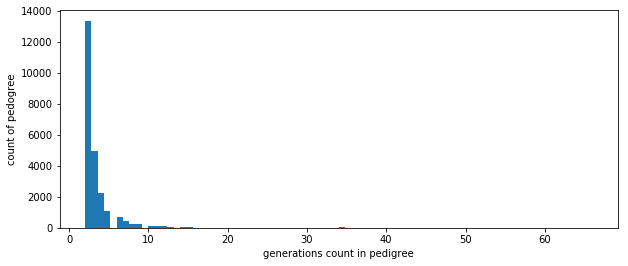

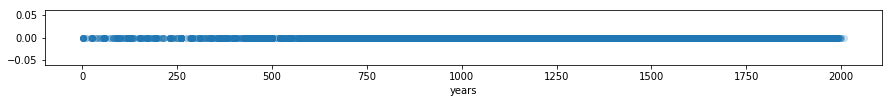

In [340]:
plt.figure(figsize=(10, 4))
plt.hist(generation_counts, bins=80)
plt.xlabel('generations count in pedigree')
plt.ylabel('count of pedogree')
plt.show()

plt.figure(figsize=(15, 1))
plt.scatter(years, np.zeros_like(years), alpha=0.2)
plt.xlabel('years')
plt.show()

Посчитайте среднюю продолжительность жизни.

In [341]:
ages = []
for pedigree in processes:
    for generation in pedigree.generations:
        for person in generation:
            if person.birthday != '' and person.deathdate != '':
                ages.append(int(person.deathdate.split('-')[0]) - \
                            int(person.birthday.split('-')[0]))

mean_age = np.mean(ages)
print(round(mean_age, 2))

57.23


## 2. Оценка закона размножения

Для начала предположим, что все выданные вам процессы являются частью одного большого процесса с общим предком. В следующем задании рассмотрим так же случай, когда все процессы являются разными.

Чтобы проводить какой-либо анализ ветвящегося процесса нужно некоторым образом оценить закон размножения. Кажется,  что для этого достаточно посчитать количество сыновей у каждого человека, получив тем самым выборку неотрицательных целых чисел. Однако, проблема в том, что данные неполные, в частности, некоторые поля могут быть не заполнены. Тем не менее обычно у человека указаны либо все дети, либо не указаны вообще. 
Таким образом, условно мы можем разделить выборку на две части: поле детей заполнено (в т.ч. если у человека на самом деле нет детей), поле детей незаполнено. Если бы первая часть выборки была бы полностью известна, что распределение можно оценить по ней. Нам же неизвестен размер выборки и количество нулевых элементов в ней. Количество положительных элементов известно.


**Математическая постановка задачи**

$\mathsf{P}_\theta$ --- неизвестное распределение из некоторого класса распределений $\mathcal{P}$ на $\mathbb{Z}_+$.

$X_1, ..., X_n$ --- выборка из распределения $\mathsf{P}_\theta$, причем $n$ и количество нулей в выборке неизвестны. 

$Y_1, ..., Y_s$ --- положительная подвыборка, которая полностью нам известна. В нашей задаче $Y_j$ --- количество сыновей у $j$-го человека среди тех, у кого есть хотя бы один сын.

Оценку параметра $\theta$ можно найти методом максимального правдоподобия:

$$\prod_{i=1}^s \mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) \to \max_\theta$$ 

В качестве классов распределений $\mathcal{P}$ рассмотрите пуассоновское и геометрическое распределения. По желанию можете рассмотреть другие классы распределений, осмысленные в данной задаче

**Внимание!** Применение метода `fit` из `scipy.stats` является некорректным в данной задаче, поскольку рассматривается усеченная выборка. Задачу максимизации нужно решить явно, выписав все формулы (которые тоже нужно прислать вместе с кодом).

После оценки параметров проведите проверку принадлежности неизвестного распределения рассматриваемому семейству распределений $\mathcal{P}$ с помощью критерия хи-квадрат, взяв для для него то распределение из $\mathcal{P}$, которое соответствует оценке максимального правдоподобия. Постарайтесь учесть все особенности проверки гипотез, которые обсуждались на семинаре. Для каждого класса постройте также график частот и функции $\mathsf{P}_\theta (y \left| Y > 0 \right).$

Для начала соберем выборку из количеств детей

In [410]:
sample = []
for pedigree in processes:
    for i, generation in enumerate(pedigree.generations):
        for person in generation:
            child_count = 0
            for child_name in person.children:
                for child_person in pedigree.generations[i - 1]:
                    if child_person.name == child_name \
                    and child_person.gender == 'male'  \
                    and person.name in child_person.parents:
                        
                        child_count += 1
                        break
            sample.append(child_count)
            
sample = np.array(sample)
positive_sample = sample[sample > 0]

### Оценка параметров методом максимального правдоподобия

#### Пуассоновское распределение

$$ \prod_{i=1}^s \mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) = \prod_{i=1}^s \frac{\mathsf{P}_\theta (Y_i)}{\mathsf{P}_\theta (Y_i > 0)} = \prod_{i=1}^s \frac{\mathsf{P}_\theta (Y_i)}{\left(1 - \mathsf{P}_\theta \left(Y_i = 0\right)\right)} = \prod_{i=1}^s \frac{\frac{\theta^{Y_i}}{Y_i!} \cdot e^{-\theta}}{1 - e^{-\theta}} $$ Прологарифмировав получим
$$ \sum_{i=1}^s \left( Y_i \cdot \ln{\theta} - \ln{\left(Y_i!\right)} - \theta - \ln{\left(1-e^{-\theta}\right)} \right) $$
Возьмем производную и приравняем к $0$
$$ \sum_{i=1}^s \left(\frac{Y_i}{\theta} - 1 - \frac{e^{-\theta}}{1 - e^{-\theta}} \right) = \sum_{i=1}^s \left(\frac{Y_i}{\theta} - \frac{1}{1 - e^{-\theta}} \right) = \cfrac{\sum_{i=1}^{s} Y_i}{\theta} - \frac{s}{1-e^{-\theta}} = 0 $$
Следовательно
$$ s = \frac{1-e^{-\theta}}{\theta} \cdot \sum_{i=1}^{s} Y_i $$

In [387]:
def bin_search(function, value):
    left = 0.0
    right = 1.0
    step = 2.0
    while (function(right) > value):
        left = right
        right = right + step
        step *= 2
    
    eps = 1e-10
    while function(left) - function(right) > eps:
        middle = (right + left) / 2
        if function(middle) < value:
            right = middle
        else:
            left = middle
    
    return left

In [797]:
summ = sum(positive_sample)
theta_poisson = bin_search(lambda x: (1 - math.exp(-x)) * summ / x, len(positive_sample))
print("theta =", theta_poisson)

theta = 1.4228944203498486


#### Геометрическое распределение

$$ \prod_{i=1}^s \mathsf{P}_\theta (Y_i \left| Y_i > 0 \right) = \prod_{i=1}^s \left(1-\theta\right)^{Y_i - 1} \theta $$ Прологарифмировав получим
$$ \sum_{i=1}^s \left( \left(Y_i - 1\right) \ln{\left(1 - \theta\right)} + \ln{\theta} \right) $$
Возьмем производную и приравняем к $0$
$$ \sum_{i=1}^s \left(\frac{1 - Y_i}{1 - \theta} + \frac{1}{\theta} \right) = \frac{s - \sum_{i=1}^{s} Y_i}{1 - \theta} + \frac{s}{\theta} = 0 $$
Следовательно
$$ \theta \left( \sum_{i=1}^{s} Y_i - s \right) = s \left( 1 - \theta \right) \quad \Rightarrow \quad \theta = \frac{1}{\overline{Y}} $$

In [796]:
theta_geom = 1 / positive_sample.mean()
print("theta =", theta_geom)

theta = 0.53340893231


### Проверка принадлежности с помощью критерия хи-квадрат

In [529]:
def count_data(sample):
    counts = []
    for i in range(0, sample.max() + 1):
        counts.append(len(sample[sample == i]))
    return counts

In [530]:
def check(x, pmf, alpha=0.05, num_tests=10, test_len=100):  
    p_values = []
    
    for i in range(num_tests):
        part_x = x[np.random.choice(len(x), test_len)]
        counts = count_data(part_x)[1:]
        res = sps.chisquare(counts, f_exp=(pmf(np.arange(len(counts)) + 1)) * sum(counts))
        print("Статистика критерия хи-квадрат:", round(res.statistic, 3))
        print("p-value: ", round(res.pvalue, 3))
        p_values.append(res.pvalue)
        
    res = multipletests(p_values, method='bonferroni')
    print("Гипотеза отклоняется:", res[0])

In [840]:
def draw(x, pmf, pmf_label=None):
    probabilities = np.array(count_data(x)[1:])
    probabilities = probabilities / sum(probabilities)
    n = int(len(probabilities) / 2)
    ranges = [(0, n), (n, len(probabilities))]
    
    plt.figure(figsize=(16, 16))
    grid = np.arange(len(counts)) + 1

    for i, r in enumerate(ranges):
        plt.subplot(2, 1, i + 1)
        
        plt.fill_between(grid[r[0]:r[1]], probabilities[r[0]:r[1]], 0, color='#0075b7', lw=5, alpha=0.15)
        plt.plot(grid[r[0]:r[1]], probabilities[r[0]:r[1]], lw=1, color='#0075b7', label="$Sample$")
        plt.scatter(grid[r[0]:r[1]], probabilities[r[0]:r[1]], color='#0075b7')
        
        plt.plot(grid[r[0]:r[1]], pmf(grid[r[0]:r[1]]), lw=1, color="#ff7100", label=pmf_label)
        plt.scatter(grid[r[0]:r[1]], pmf(grid[r[0]:r[1]]), color="#ff7100")

        plt.xticks(range(r[0] + 1, r[1] + 1))
        plt.xlim(r[0] + 1, r[1])
        plt.ylim(0)

        plt.title("Графики при $x \\in [" + 
                  str(r[0] + 1) + ", " + str(r[1]) +
                  "]$", y=1.03, fontsize=16)
        plt.xlabel("Количество сыновей", fontsize=14)
        plt.ylabel('Вероятность', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=14)
    plt.show()

#### Пуассоновское распределение

Разделим график на $2$ части, чтобы лучше понимать как ведут себя функции при маленьких значениях.

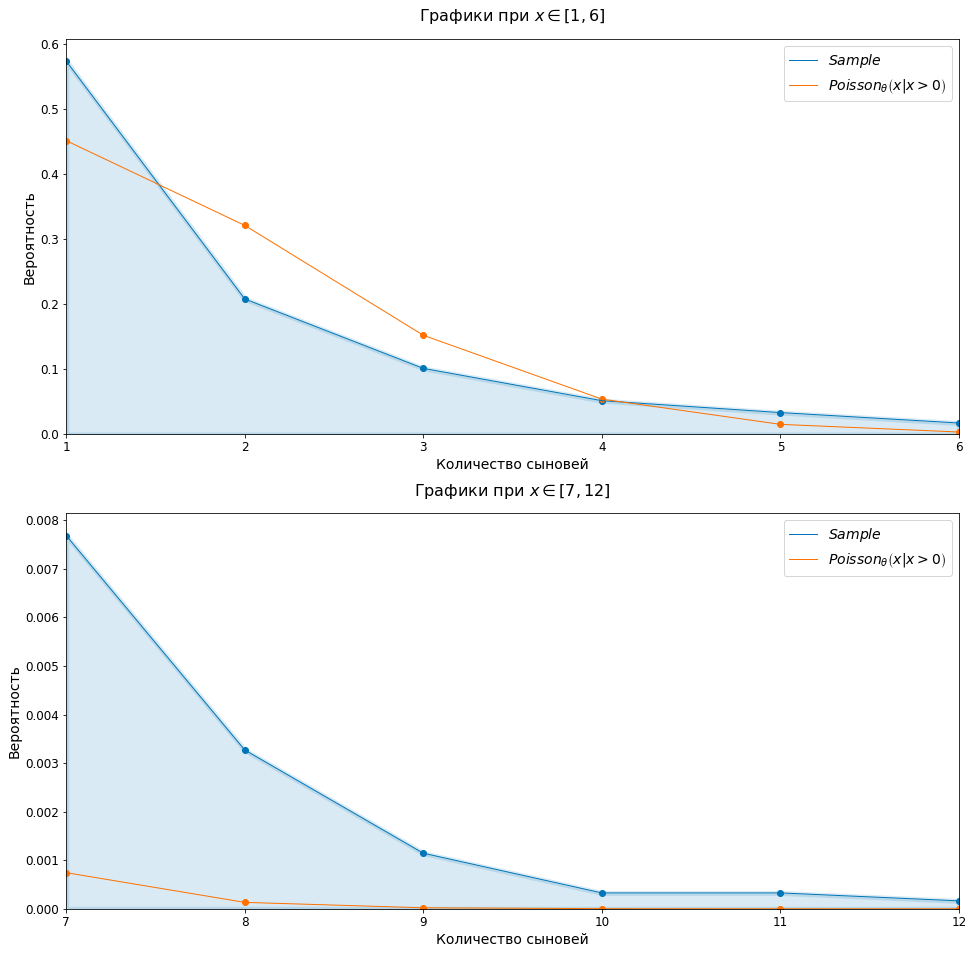

In [841]:
draw(positive_sample, 
     (lambda x: sps.poisson(theta_poisson).pmf(x) / (1 - math.exp(-theta_poisson))), 
     "$Poisson_{\\theta}\\left(x|x>0\\right)$")

Уже на глаз видно, что ничего хорошего не выйдет.

Далее запустим multipletest со случайным выбором небольшой группы людей, и проверим что он нам скажет

In [802]:
check(positive_sample, (lambda x: sps.poisson(theta_poisson).pmf(x) / (1 - math.exp(-theta_poisson))))

Статистика критерия хи-квадрат: 111.205
p-value:  0.0
Статистика критерия хи-квадрат: 53.414
p-value:  0.0
Статистика критерия хи-квадрат: 13.968
p-value:  0.007
Статистика критерия хи-квадрат: 73.249
p-value:  0.0
Статистика критерия хи-квадрат: 30.362
p-value:  0.0
Статистика критерия хи-квадрат: 26108.811
p-value:  0.0
Статистика критерия хи-квадрат: 9.966
p-value:  0.076
Статистика критерия хи-квадрат: 97.815
p-value:  0.0
Статистика критерия хи-квадрат: 18.411
p-value:  0.001
Статистика критерия хи-квадрат: 136.344
p-value:  0.0
Гипотеза отклоняется: [ True  True False  True  True  True False  True  True  True]


Как видно, результаты явно не в пользу пуассоновского распределения

#### Геометрическое распределение

Проделаем тоже самое для геометрического

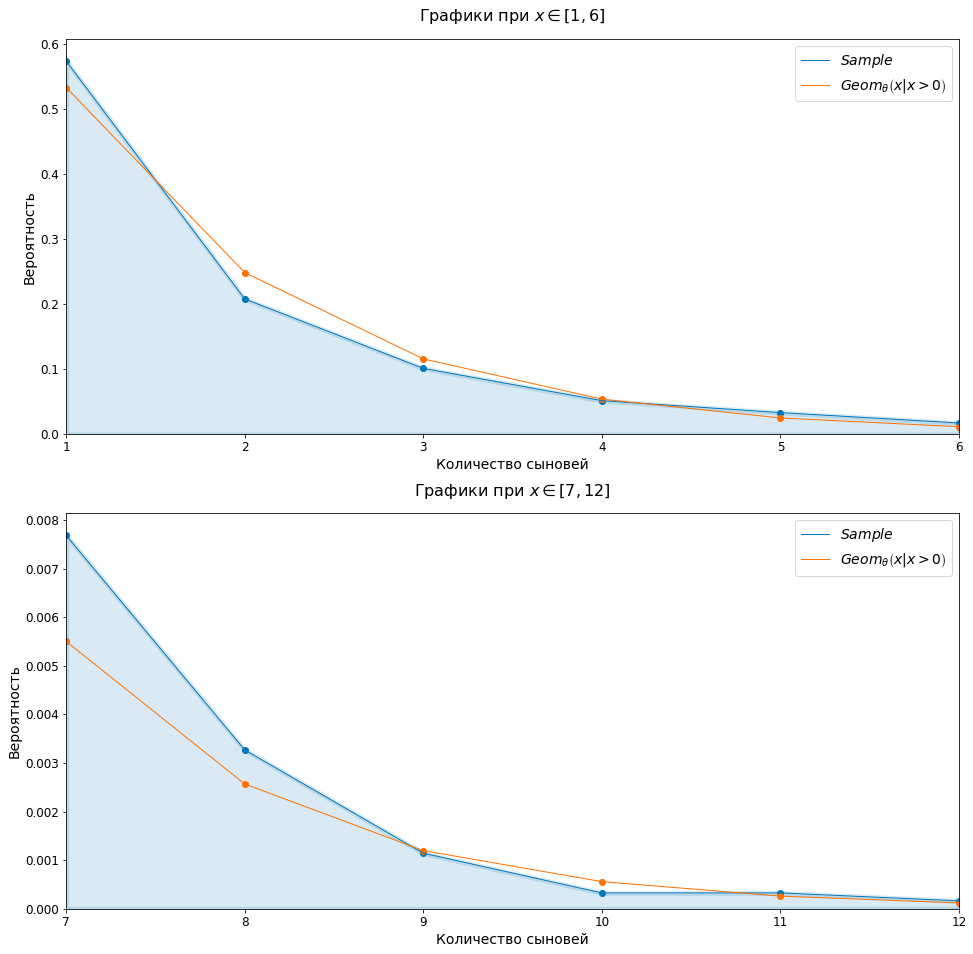

In [842]:
draw(positive_sample, sps.geom(theta_geom).pmf, "$Geom_{\\theta}\\left(x|x>0\\right)$")

Значительно лучше, некоторые точки практически идентичны

In [801]:
check(positive_sample, sps.geom(theta_geom).pmf)

Статистика критерия хи-квадрат: 17.65
p-value:  0.014
Статистика критерия хи-квадрат: 6.129
p-value:  0.525
Статистика критерия хи-квадрат: 4.528
p-value:  0.717
Статистика критерия хи-квадрат: 13.782
p-value:  0.017
Статистика критерия хи-квадрат: 15.077
p-value:  0.02
Статистика критерия хи-квадрат: 6.788
p-value:  0.237
Статистика критерия хи-квадрат: 8.431
p-value:  0.208
Статистика критерия хи-квадрат: 5.184
p-value:  0.269
Статистика критерия хи-квадрат: 14.097
p-value:  0.015
Статистика критерия хи-квадрат: 11.37
p-value:  0.078
Гипотеза отклоняется: [False False False False False False False False False False]


Ну тут результаты говорят сами за себя

** Вывод: ** после проверки критерием хи-квадрат распределений, полученных после метода максимального правдоподобия, выяснилось что пуассоновское распределение очень плохо оцеивает количество детей, а геометрическое наоборот хорошо, что видно из графиков.